In [44]:
tar_path = 'data/'
ball_video_path = 'Vid_A_ball'
cup_video_path = 'Vid_B_cup'
person_video_path = 'Vid_D_person'
extract_to = 'data'

In [45]:
import tarfile

with tarfile.open(tar_path+ball_video_path+'.tar.xz') as f:
    f.extractall(extract_to)
    
with tarfile.open(tar_path+cup_video_path+'.tar.xz') as f:
    f.extractall(extract_to)
    
with tarfile.open(tar_path+person_video_path+'.tar.xz') as f:
    f.extractall(extract_to)

In [46]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import time
import numpy as np
from train import *
from networks import *
from ResED import *
from functions import *
from imageloader import *
from torch import optim
%matplotlib inline

# Load Cropped Frames

In [47]:
ball_frames_cropped, ball_height_cropped, ball_width_cropped = get_cropped_frames(tar_path + ball_video_path)
cup_frames_cropped, cup_height_cropped, cup_width_cropped = get_cropped_frames(tar_path + cup_video_path)
person_frames_cropped, person_height_cropped, person_width_cropped = get_cropped_frames(tar_path + person_video_path)

# Load Training Image

## 1. Ball

In [48]:
ball_img_name = 'img0002.jpg'
ball_img_path = tar_path + ball_video_path + '/' + ball_img_name
ball_crop_start_point = (200, 115)   
ball_crop_end_point = (245, 160)
ball_center_coordinates = (222, 136)
ball_radius = 22
ball_padding = 35

In [49]:
ball_img, ball_flatten_labels, ball_foreground, ball_background, ball_marked_img = load_image_circle_flatten_labels(ball_img_path, ball_crop_start_point, ball_crop_end_point,
                                 ball_padding, ball_center_coordinates, ball_radius, thickness=1)

<IPython.core.display.Javascript object>


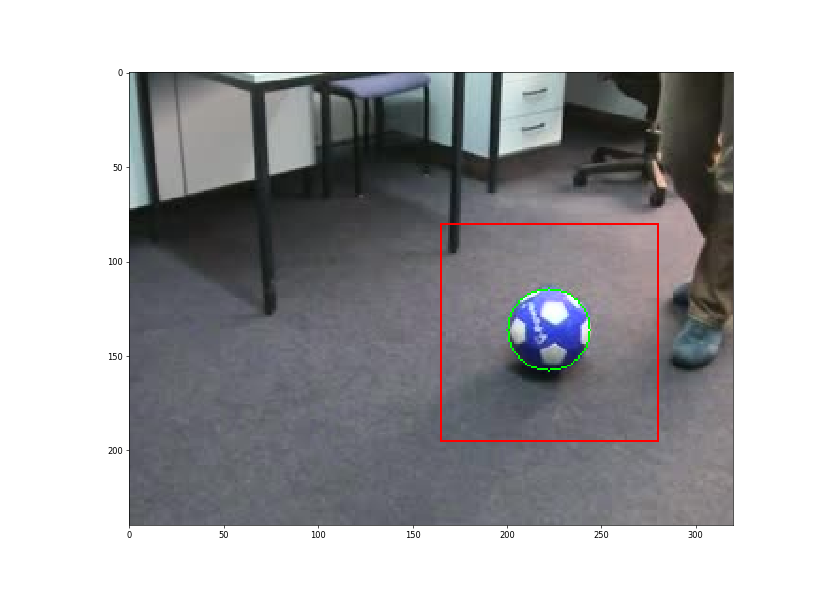

In [7]:
%matplotlib notebook
fig = plt.figure(figsize=(14, 10), dpi= 50, facecolor='w', edgecolor='k')
plt.imshow(ball_marked_img)
plt.show()

In [ ]:
plt.close()

<IPython.core.display.Javascript object>


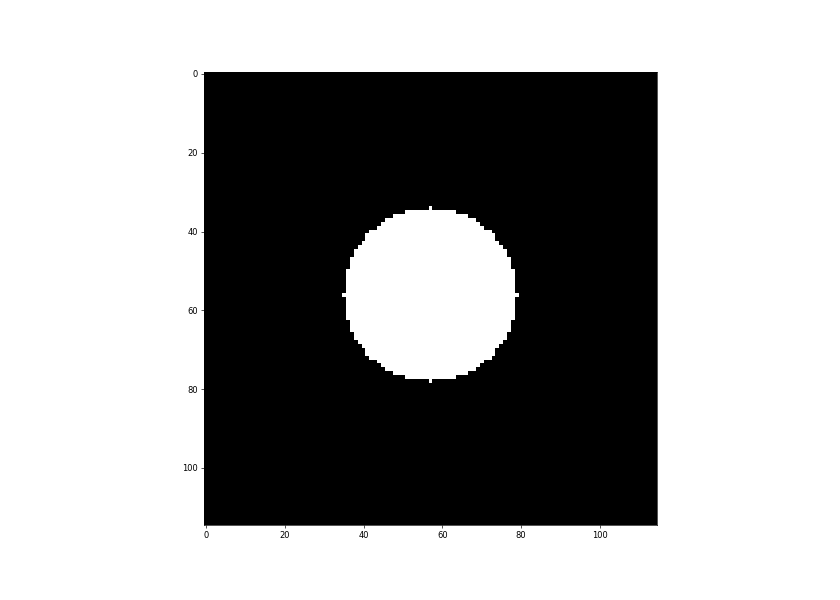

In [8]:
test_flatten_labels = ball_flatten_labels.reshape((ball_img.shape[-2], ball_img.shape[-1]))
fig = plt.figure(figsize=(14, 10), dpi= 50, facecolor='w', edgecolor='k')
plt.imshow(test_flatten_labels, cmap=plt.cm.gray)
plt.show()

In [11]:
plt.close()

## 2. Cup

In [7]:
cup_img_name = 'img0002.jpg'
cup_img_path = tar_path + cup_video_path + '/' + cup_img_name
cup_start_point = (124, 92)   
cup_end_point = (171, 150)
cup_start_point2 = (171,105)   
cup_end_point2 = (188, 137)
cup_remove_label_rect = ((171, 111), (182, 132))
cup_padding = 35

In [8]:
cup_img, cup_flatten_labels, cup_foreground, cup_background, cup_marked_img = load_image_cup_flatten_labels(cup_img_path, cup_start_point,
                                                                                                            cup_end_point, cup_start_point2, cup_end_point2, cup_padding, cup_remove_label_rect, thickness=1)

<IPython.core.display.Javascript object>


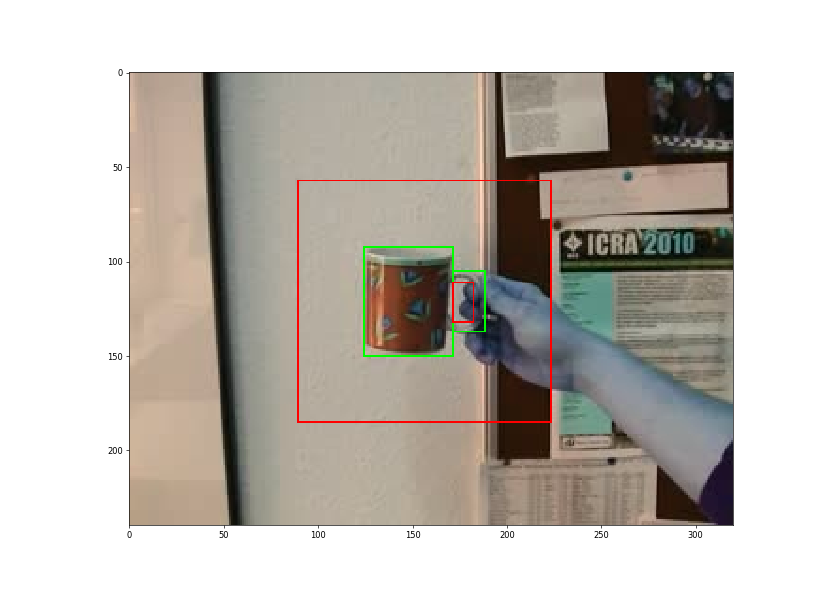

In [11]:
%matplotlib notebook
fig = plt.figure(figsize=(14, 10), dpi= 50, facecolor='w', edgecolor='k')
plt.imshow(cup_marked_img)
plt.show()

In [ ]:
plt.close()

<IPython.core.display.Javascript object>


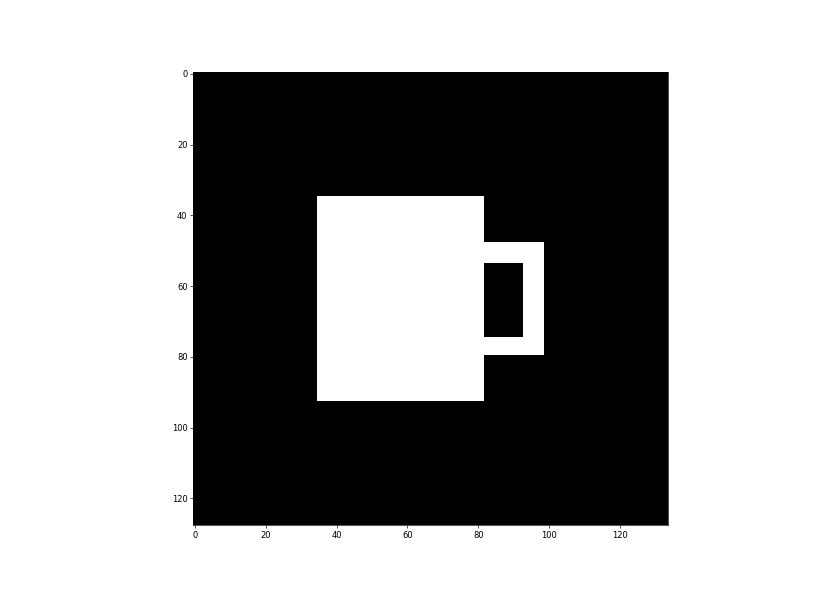

In [14]:
test_flatten_labels = cup_flatten_labels.reshape((cup_img.shape[-2], cup_img.shape[-1]))
fig = plt.figure(figsize=(14, 10), dpi= 50, facecolor='w', edgecolor='k')
plt.imshow(test_flatten_labels, cmap=plt.cm.gray)
plt.show()

In [13]:
plt.close()

## 3. Person

In [9]:
person_img_name = 'img0002.jpg'
person_img_path = tar_path + person_video_path + '/' + person_img_name
# person_start_point = (136, 55)
# person_end_point = (179, 187)
person_rect_points = [((146, 78), (170, 84)),
                      ((138, 85), (170, 133)),
                      ((170, 84), (178, 133)),
                      ((148, 132), (157, 184)),
                      ((162, 134), (171, 187)), 
                      ((141, 182), (149, 186)),
                      ((154, 74), (162, 77))]
face_center = (157, 67)
face_radius = 9
# person_padding = 35
person_padding_rect = ((101, 20), (214, 222))

In [10]:
person_img, person_flatten_labels, person_foreground, person_background, person_marked_img = load_image_person_flatten_labels(person_img_path, person_rect_points, face_center, face_radius, person_padding_rect, thickness=1)

<IPython.core.display.Javascript object>


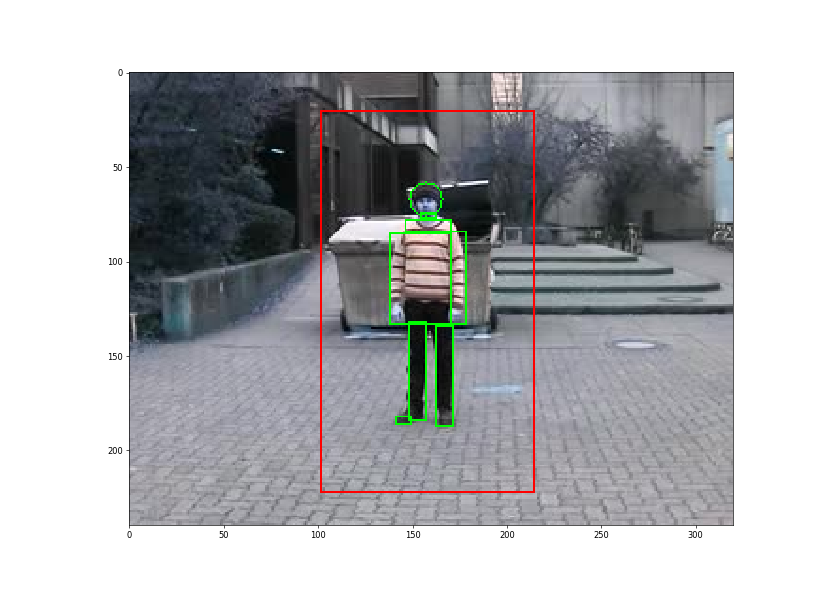

In [17]:
%matplotlib notebook
fig = plt.figure(figsize=(14, 10), dpi= 50, facecolor='w', edgecolor='k')
plt.imshow(person_marked_img)
plt.show()

In [ ]:
plt.close()

<IPython.core.display.Javascript object>


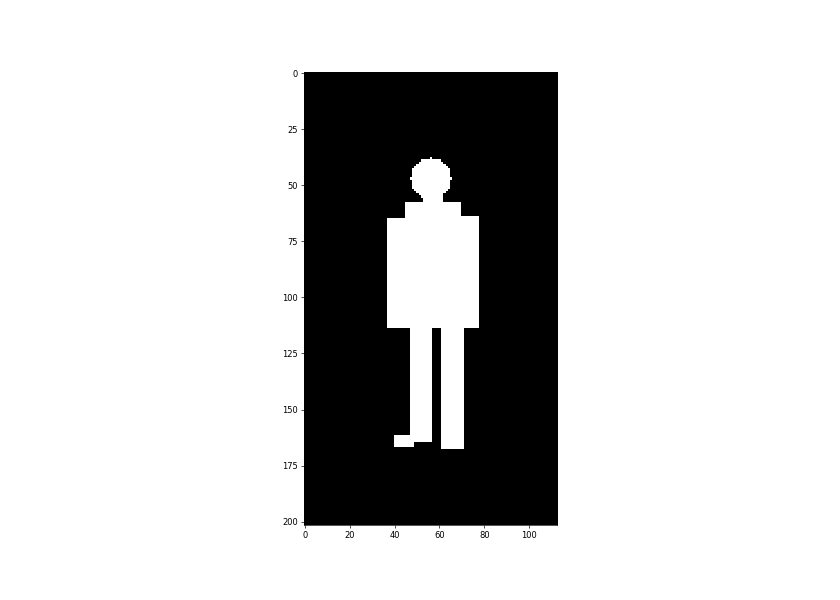

In [18]:
test_flatten_labels = person_flatten_labels.reshape((person_img.shape[-2], person_img.shape[-1]))
fig = plt.figure(figsize=(14, 10), dpi= 50, facecolor='w', edgecolor='k')
plt.imshow(test_flatten_labels, cmap=plt.cm.gray)
plt.show()

In [ ]:
plt.close()

In [19]:
%matplotlib inline

## Model training

### 1.1 Ball

In [50]:
model_path = 'ball_ResED_cpu_1'
video_path = 'Videos/'+model_path+'.avi'

In [12]:
last_out_channel = 32
model = ResED(in_channels=3,
            n_classes=last_out_channel,
            depth=2,
            wf=5,
            padding=1,
            batch_norm=True,
            up_mode='upconv')

In [13]:
print(model)

ResED(
  (down_path): ModuleList(
    (0): ResED_DownBlock(
      (block1): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (block2): Sequential(
        (0): ReLU()
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResED_DownBlock(
      (block1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (block2): Sequential(
        (0): ReLU()
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (up_path): ModuleList(
    (0): ResED_UpBlock(
      (up): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ResED_UpBlock(
      (up): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)


In [14]:
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
margin = 50
print("margin:", margin)
criterion = TripletLossMiniBatch(margin)
n_epochs = 1
print(ball_img.shape)

margin: 50
torch.Size([1, 3, 115, 115])


In [15]:
model, ball_time_passed = train_cpu_optimized(model, criterion, ball_img, ball_flatten_labels, optimizer, ball_foreground, ball_background, num_epochs=n_epochs, batch_size=1024, num_batches=1)

loss: 27.804577
Time passed: 1.841353999999999


In [16]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    embeddings = model(ball_img)
embeddings = embeddings.data.numpy()

In [17]:
centroids = get_centroids(embeddings, ball_foreground, ball_background)

correct: 12787, wrong: 438, accuracy: 96.68809073724007%


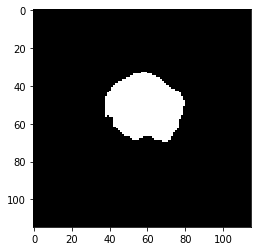

In [18]:
labels_shape = ball_img.shape[-2], ball_img.shape[-1]
heat_map = embeddings_accuracy(embeddings, ball_flatten_labels, labels_shape, centroids, num_classes=2)
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()

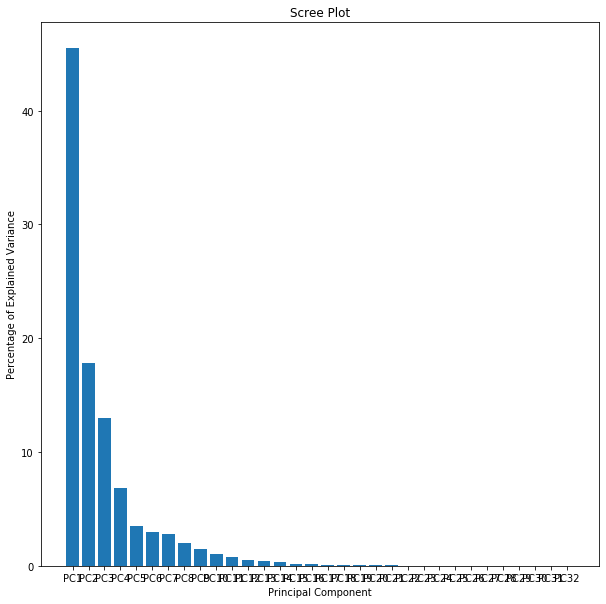

embedding2    -0.250962
embedding28   -0.248520
embedding31   -0.244022
dtype: float64


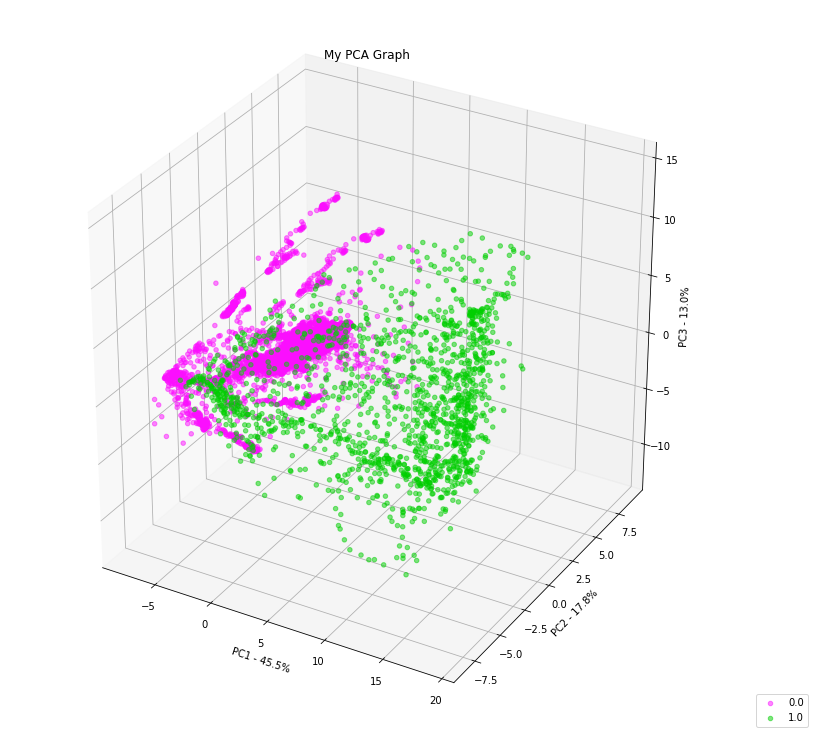

In [19]:
plot_PCA(embeddings, ball_flatten_labels, out_features_size=out_features_size,classes= [0., 1.], colors=['#fc0fff', '#00cf00'], is_3D=True, draw_PCA_per_varc=True, figure_size=(10,10), top_range_loadingfactors=(0, 3))

In [20]:
frames_step = 3
vmin, vmax = 0, 2
real_heat_maps = easy_create_real_video(model, centroids, ball_frames_cropped, video_path, ball_width_cropped,
                                        ball_height_cropped, froucc=cv2.VideoWriter_fourcc('M','J','P','G'),
                                        use_gpu=True, fps=10, frames_step=frames_step, num_classes=2,
                                        ret_heat_maps=True, heatmap_path = 'heatmaps/heatmap', img_ext = '.jpg', vmin=0, vmax=2)

Generate Heat Maps: 100%|██████████| 100/100 [00:00<00:00, 121.59it/s]


Time Elapsed (get_heatmaps func) 0m 3s
Model time mean = 0.043654247800000004
Model time std = 0.17637639556646345
Heatmap time mean = 0.0376844176
Heatmap time std = 0.015296310060692753
Total time mean = 0.0813386654
Total time std = 0.17901703695267707


<Figure size 432x288 with 0 Axes>

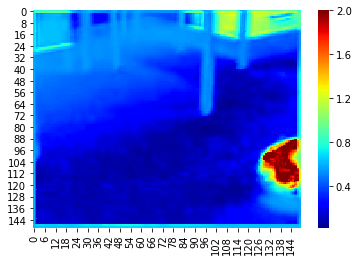

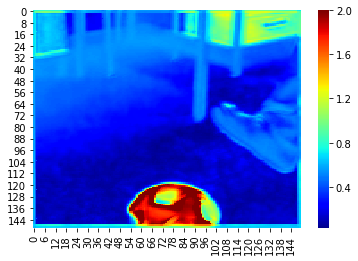

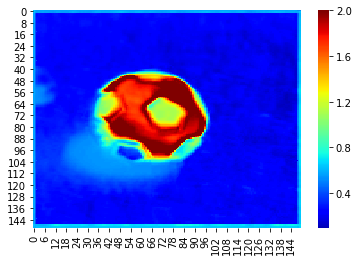

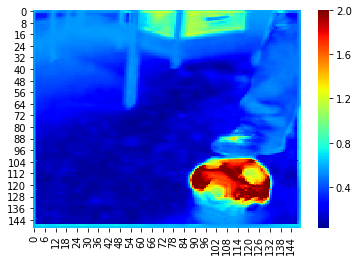

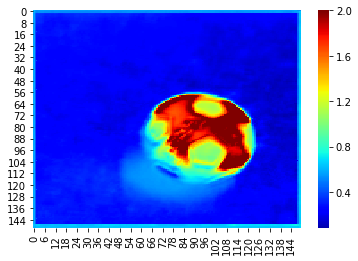

In [21]:
vmin, vmax = 0, 2

heat_map = sns.heatmap(real_heat_maps[0], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax)
plt.show()
heat_map = sns.heatmap(real_heat_maps[25], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax) 
plt.show()
heat_map = sns.heatmap(real_heat_maps[50], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax) 
plt.show()
heat_map = sns.heatmap(real_heat_maps[75], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax) 
plt.show()
heat_map = sns.heatmap(real_heat_maps[-1], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax)
plt.show()

### 2.1 Cup

In [22]:
model_path = 'cup_ResED_cpu_1'
video_path = 'Videos/'+model_path+'.avi'

In [23]:
last_out_channel = 8
model = ResED(in_channels=3,
            n_classes=last_out_channel,
            depth=2,
            wf=5,
            padding=1,
            batch_norm=True,
            up_mode='upconv')

In [24]:
print(model)

ResED(
  (down_path): ModuleList(
    (0): ResED_DownBlock(
      (block1): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (block2): Sequential(
        (0): ReLU()
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResED_DownBlock(
      (block1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (block2): Sequential(
        (0): ReLU()
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (up_path): ModuleList(
    (0): ResED_UpBlock(
      (up): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ResED_UpBlock(
      (up): ConvTranspose2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)


In [25]:
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
margin = 60
print("margin:", margin)
criterion = TripletLossMiniBatch(margin)
n_epochs = 30
print(cup_img.shape)

margin: 60
torch.Size([1, 3, 128, 134])


In [26]:
model, cup_time_passed = train_cpu_optimized(model, criterion, cup_img, cup_flatten_labels, optimizer, cup_foreground, cup_background, num_epochs=n_epochs, batch_size=2056, num_batches=1)

loss: 69.591568
loss: 50.068451
loss: 46.809742
loss: 46.104759
loss: 46.584351
loss: 45.452377
loss: 44.177544
loss: 43.851974
loss: 43.466576
loss: 43.012459
loss: 40.946312
loss: 39.642014
loss: 39.329842
loss: 37.247265
loss: 36.466953
loss: 33.048927
loss: 30.045561
loss: 28.816700
loss: 27.482258
loss: 26.057173
loss: 24.092892
loss: 23.569828
loss: 21.135672
loss: 20.998737
loss: 19.351133
loss: 17.551086
loss: 16.813049
loss: 14.569967
loss: 14.742493
loss: 13.640975
Time passed: 52.26016200000001


In [27]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    embeddings = model(cup_img)
embeddings = embeddings.data.numpy()

In [28]:
centroids = get_centroids(embeddings, cup_foreground, cup_background)

correct: 16387, wrong: 765, accuracy: 95.53987873134328%


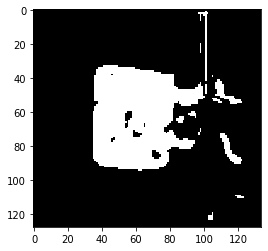

In [29]:
labels_shape = cup_img.shape[-2], cup_img.shape[-1]
heat_map = embeddings_accuracy(embeddings, cup_flatten_labels, labels_shape, centroids, num_classes=2)
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()

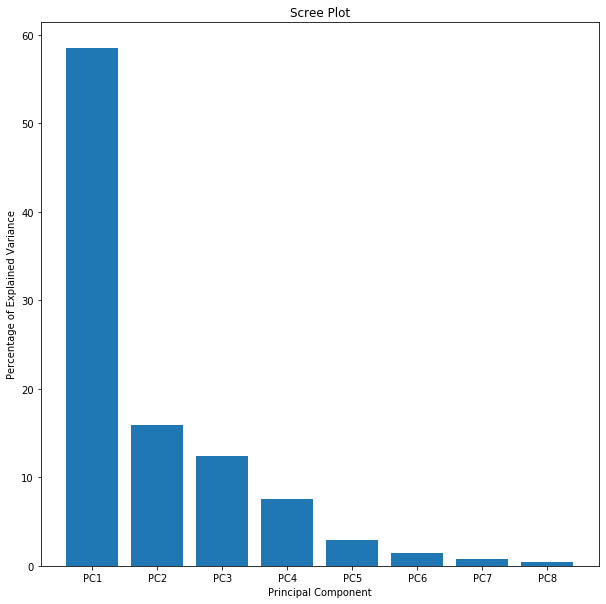

embedding8   -0.446571
embedding6    0.442080
embedding7    0.422986
dtype: float64


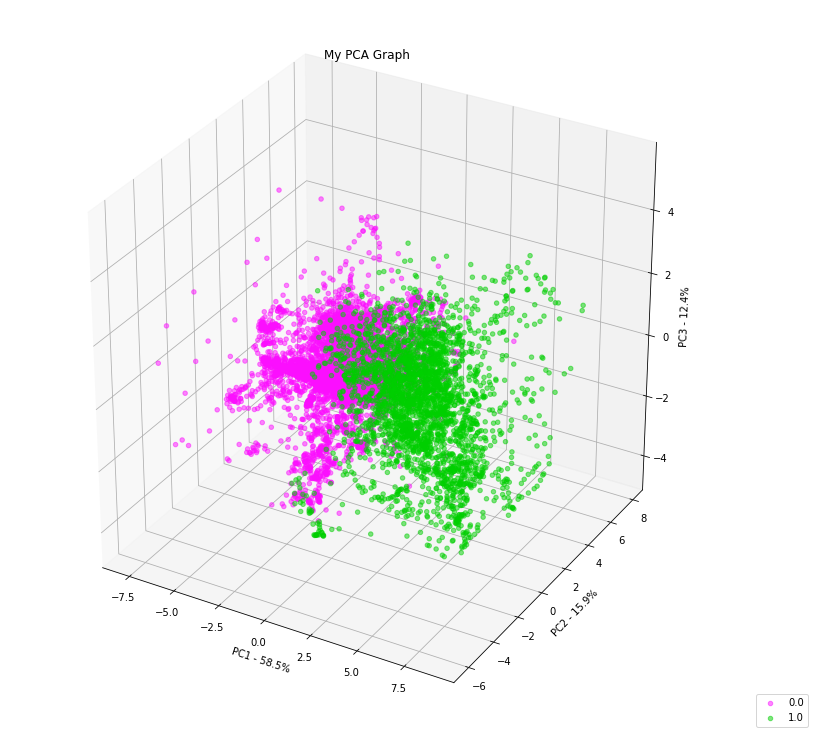

In [30]:
plot_PCA(embeddings, cup_flatten_labels, out_features_size=out_features_size,classes= [0., 1.], colors=['#fc0fff', '#00cf00'], is_3D=True, draw_PCA_per_varc=True, figure_size=(10,10), top_range_loadingfactors=(0, 3))

In [31]:
num_classes = 2
frames_step = 3
vmin, vmax = 0, 5
frames_step = 3
frame_range=(0, 300)
fps = 10
ret_heat_maps = True
use_gpu = True

real_heat_maps = easy_create_real_video(model, centroids, cup_frames_cropped, video_path, cup_width_cropped,
                                        cup_height_cropped, froucc=cv2.VideoWriter_fourcc('M','J','P','G'),
                                        use_gpu=use_gpu, fps=fps, frame_range=frame_range, frames_step=frames_step, num_classes=num_classes,
                                        ret_heat_maps=ret_heat_maps, heatmap_path = 'heatmaps/heatmap', img_ext = '.jpg', vmin=vmin, vmax=vmax)

Generate Heat Maps: 100%|██████████| 100/100 [00:00<00:00, 309.68it/s]


Time Elapsed (get_heatmaps func) 0m 0s
Model time mean = 0.015238243700000001
Model time std = 0.005376844005607872
Heatmap time mean = 0.016660933500000003
Heatmap time std = 0.0006478575776193024
Total time mean = 0.031899177199999997
Total time std = 0.005524049754748066


<Figure size 432x288 with 0 Axes>

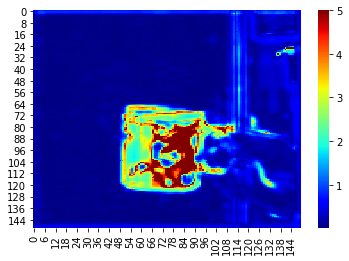

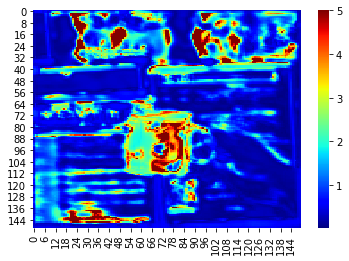

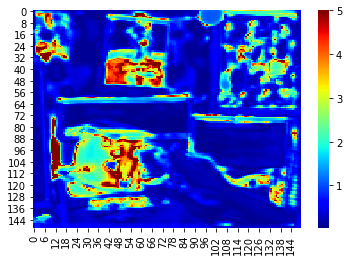

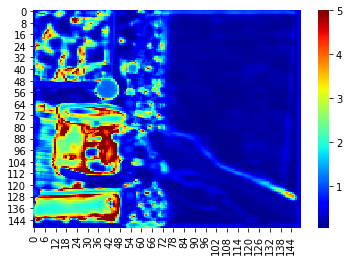

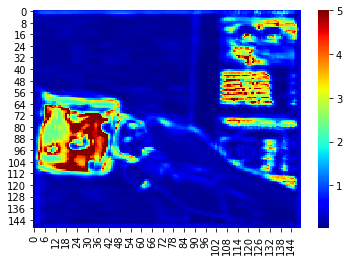

In [32]:
vmin, vmax = 0, 5

heat_map = sns.heatmap(real_heat_maps[0], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax)
plt.show()
heat_map = sns.heatmap(real_heat_maps[25], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax) 
plt.show()
heat_map = sns.heatmap(real_heat_maps[50], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax) 
plt.show()
heat_map = sns.heatmap(real_heat_maps[75], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax) 
plt.show()
heat_map = sns.heatmap(real_heat_maps[-1], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax)
plt.show()

### 3.1 Person

In [33]:
model_path = 'person_ResED_cpu_1'
video_path = 'Videos/'+model_path+'.avi'

In [34]:
last_out_channel = 8
model = ResED(in_channels=3,
            n_classes=last_out_channel,
            depth=2,
            wf=5,
            padding=1,
            batch_norm=True,
            up_mode='upconv')

In [35]:
print(model)

ResED(
  (down_path): ModuleList(
    (0): ResED_DownBlock(
      (block1): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (block2): Sequential(
        (0): ReLU()
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResED_DownBlock(
      (block1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (block2): Sequential(
        (0): ReLU()
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (up_path): ModuleList(
    (0): ResED_UpBlock(
      (up): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ResED_UpBlock(
      (up): ConvTranspose2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)


In [36]:
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
margin = 60
print("margin:", margin)
criterion = TripletLossMiniBatch(margin)
n_epochs = 25
print(person_img.shape)

margin: 60
torch.Size([1, 3, 202, 113])


In [37]:
model, person_time_passed = train_cpu_optimized(model, criterion, person_img, person_flatten_labels, optimizer, person_foreground, person_background, num_epochs=n_epochs, batch_size=2056, num_batches=1)

loss: 63.938171
loss: 50.550385
loss: 47.057121
loss: 46.774040
loss: 47.018406
loss: 45.277145
loss: 45.287369
loss: 43.675034
loss: 42.664070
loss: 39.169823
loss: 37.081989
loss: 34.618507
loss: 32.945076
loss: 32.044998
loss: 30.638008
loss: 30.685869
loss: 28.266506
loss: 26.672039
loss: 27.499451
loss: 26.034031
loss: 24.900517
loss: 24.882648
loss: 22.177687
loss: 23.409424
loss: 21.685331
Time passed: 52.374495000000024


In [38]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    embeddings = model(person_img)
embeddings = embeddings.data.numpy()

In [39]:
centroids = get_centroids(embeddings, person_foreground, person_background)

correct: 21252, wrong: 1574, accuracy: 93.10435468325593%


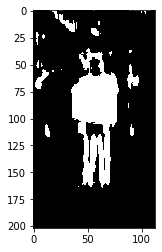

In [40]:
labels_shape = person_img.shape[-2], person_img.shape[-1]
heat_map = embeddings_accuracy(embeddings, person_flatten_labels, labels_shape, centroids, num_classes=2)
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()

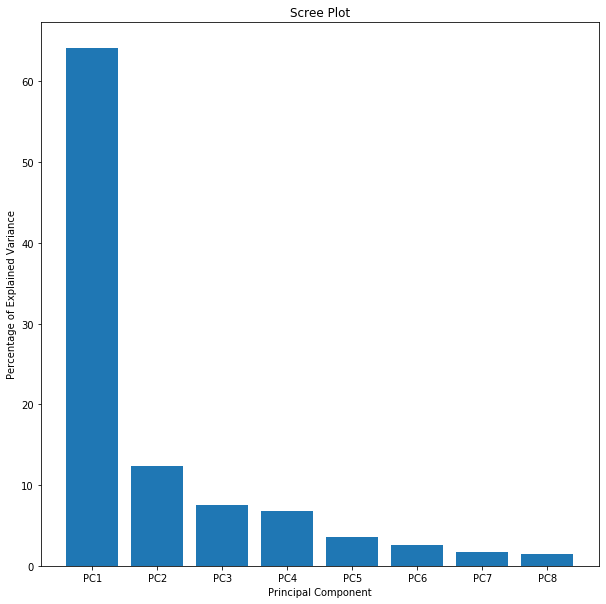

embedding7   -0.412102
embedding2    0.396256
embedding8    0.392281
dtype: float64


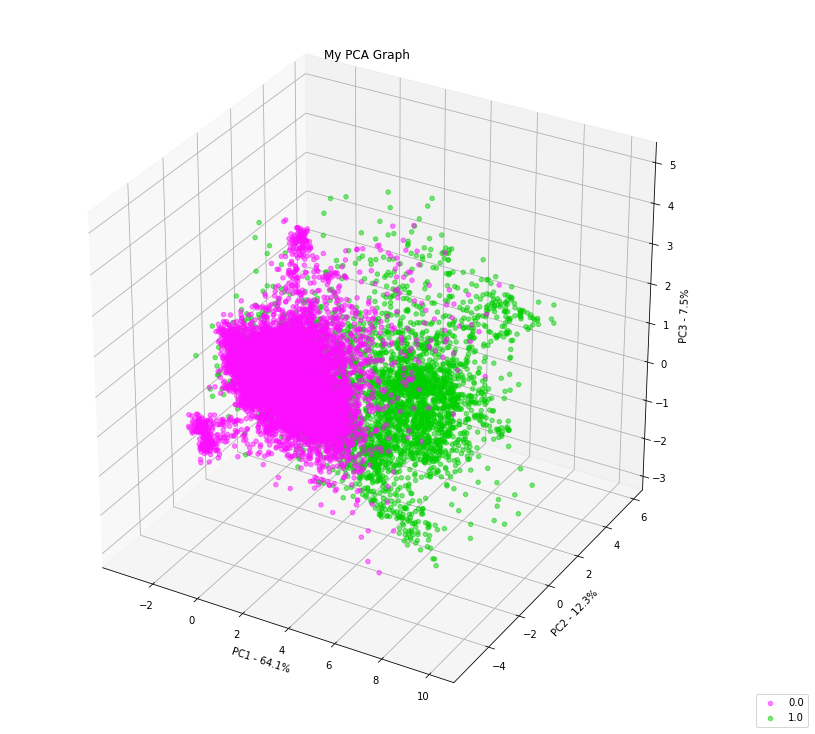

In [41]:
plot_PCA(embeddings, person_flatten_labels, out_features_size=out_features_size,classes= [0., 1.], colors=['#fc0fff', '#00cf00'], is_3D=True, draw_PCA_per_varc=True, figure_size=(10,10), top_range_loadingfactors=(0, 3))

In [42]:
num_classes = 2
frames_step = 3
vmin, vmax = 0, 2
frames_step = 3
frame_range=(0, 600)
fps = 10
ret_heat_maps = True
use_gpu = True

real_heat_maps = easy_create_real_video(model, centroids, person_frames_cropped, video_path, person_width_cropped,
                                        person_height_cropped, froucc=cv2.VideoWriter_fourcc('M','J','P','G'),
                                        use_gpu=use_gpu, fps=fps, frame_range=frame_range, frames_step=frames_step, num_classes=num_classes,
                                        ret_heat_maps=ret_heat_maps, heatmap_path = 'heatmaps/heatmap', img_ext = '.jpg', vmin=vmin, vmax=vmax)

Generate Heat Maps: 100%|██████████| 200/200 [00:00<00:00, 306.69it/s]


Time Elapsed (get_heatmaps func) 0m 1s
Model time mean = 0.015644874
Model time std = 0.00825369104407095
Heatmap time mean = 0.0165792597
Heatmap time std = 0.0009463720678950273
Total time mean = 0.0322241337
Total time std = 0.008524294946759017


<Figure size 432x288 with 0 Axes>

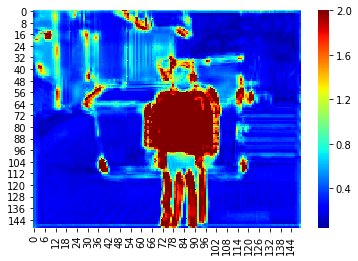

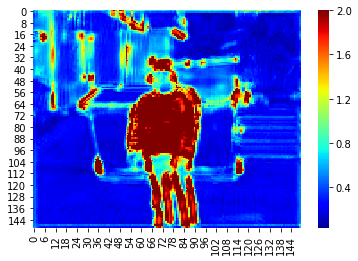

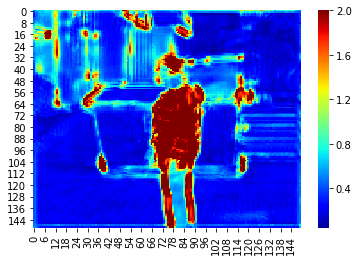

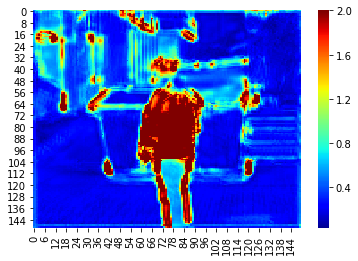

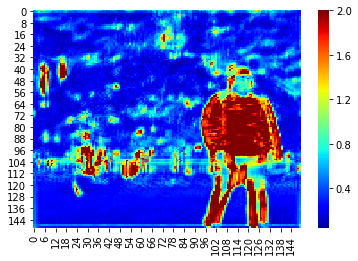

In [43]:
vmin, vmax = 0, 2

heat_map = sns.heatmap(real_heat_maps[0], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax)
plt.show()
heat_map = sns.heatmap(real_heat_maps[25], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax) 
plt.show()
heat_map = sns.heatmap(real_heat_maps[50], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax) 
plt.show()
heat_map = sns.heatmap(real_heat_maps[75], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax) 
plt.show()
heat_map = sns.heatmap(real_heat_maps[-1], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax)
plt.show()